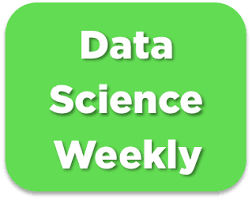

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [101]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


# Read file with labels

In [102]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [103]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [104]:
data.describe()

,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [105]:
data.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

* Il n'y a pas de valeurs manquantes : pas besoin d'imputation
* Pas besoin de label encoder
* new_user, country, source est catégorielle : mais pas besoin d'encoder
* age et pages visitées sont quantitatives : on doit les normaliser
* ATTENTION : outliers dans Age : 123 ans ! 

c:\Users\Celine\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='age', ylabel='count'>

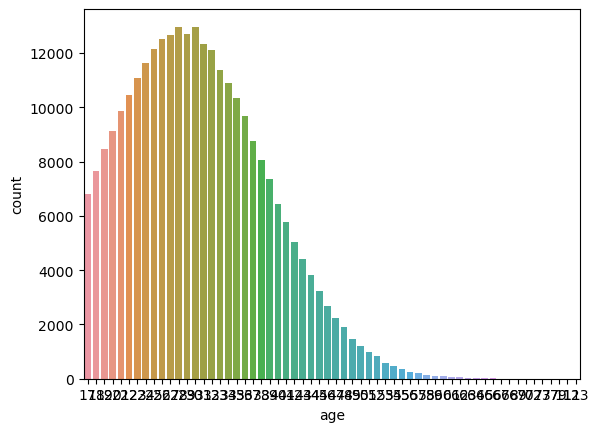

In [106]:
sns.countplot(data['age'])

In [107]:
data['age'].value_counts()

28     12972
30     12956
29     12710
27     12668
26     12525
31     12327
25     12157
32     12111
24     11647
33     11392
23     11097
34     10911
22     10471
35     10352
21      9870
36      9668
20      9131
37      8773
19      8452
38      8067
18      7662
39      7343
17      6825
40      6451
41      5783
42      5029
43      4423
44      3808
45      3249
46      2693
47      2255
48      1898
49      1467
50      1213
51       990
52       835
53       571
54       459
55       352
56       251
57       211
58       147
59       115
60        86
61        63
62        50
63        29
64        26
65        14
66         9
67         5
68         2
70         2
111        1
72         1
69         1
73         1
79         1
123        1
77         1
Name: age, dtype: int64

In [108]:
#filtrer que les ages < 90
data = data[data['age'] < 90]

# Explore dataset

In [109]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [110]:
# Visualize pairwise dependencies before taking out outliers
fig = px.scatter_matrix(data_sample)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height=800, width = 800)
fig.show()

In [111]:
# pip install kaleido

# Make your model
We need a classification model as Y (target = conversion) is categorical ! 

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [112]:
data.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [113]:
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target_variable = 'converted'

In [114]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [115]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [116]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
#print("Convert pandas DataFrames to numpy arrays...")
#X_train = X_train.values
#X_test = X_test.values
#Y_train = Y_train.values
#Y_test = Y_test.values
#print("...Done")

#print(X_train[0:5,:])
#print(X_test[0:2,:])
#print()
#print(Y_train[0:5])
#print(Y_test[0:2])

## Training pipeline

In [117]:
data['country'].value_counts()

US         160124
China       69122
UK          43640
Germany     11692
Name: country, dtype: int64

In [118]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

num_featureencoder = StandardScaler()
num_features = ['age', 'total_pages_visited']

cat_featureencoder = OneHotEncoder(drop='first')
cat_features = ['country', 'new_user', 'source']

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_featureencoder, num_features),
        ('cat', cat_featureencoder, cat_features)
    ])

print("Preprocessing done")

Encoding categorical features and standardizing numerical features...
Preprocessing done


In [119]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

Performing preprocessings on train set...
...Done.
[[ 0.53681877  0.33742062  0.          0.          1.          0.
   0.          1.        ]
 [-0.55226096  0.03809786  0.          0.          1.          0.
   0.          0.        ]
 [ 0.17379219 -0.85987044  0.          0.          1.          1.
   0.          1.        ]
 [ 1.38388079  0.33742062  0.          1.          0.          1.
   0.          1.        ]
 [ 1.26287193 -0.26122491  0.          0.          0.          0.
   0.          1.        ]]



In [120]:
# Train model
print("Train model...")
classifier = LogisticRegression() # 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [121]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [122]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.4312521   0.63674339  0.          0.          1.          1.
   0.          1.        ]
 [ 2.10993394 -0.85987044  0.          0.          1.          1.
   0.          1.        ]
 [-1.27831412 -1.15919321  0.          0.          1.          0.
   0.          1.        ]
 [-1.0362964  -0.85987044  0.          0.          1.          1.
   0.          0.        ]
 [-0.55226096  0.93606615  0.          0.          1.          0.
   1.          0.        ]]


In [123]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [124]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7649993258729944
f1-score on test set :  0.7482517482517483


In [125]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246960    940]
 [  2546   5674]]

Confusion matrix on test set : 
[[27384   116]
 [  316   642]]



**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [126]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)
Y_total_pred = classifier.predict(X)

print("f1-score on train set : ", f1_score(Y, Y_total_pred))

f1-score on train set :  0.7635090261426072


In [129]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
#print("Convert pandas DataFrames to numpy arrays...")
#X_without_labels = X_without_labels.values
#print("...Done")

# print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)


In [130]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.31024324  3.33064829  0.          1.          0.          0.
   0.          1.        ]
 [-1.0362964   0.03809786  0.          1.          0.          1.
   1.          0.        ]
 [ 0.17379219 -1.15919321  0.          0.          0.          1.
   0.          1.        ]
 [ 0.17379219  0.33742062  0.          0.          1.          1.
   0.          0.        ]
 [-0.67326982 -0.56054768  0.          0.          0.          0.
   0.          1.        ]]


In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data_end = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data_end)
Y_predictions.to_csv('conversion_data_test_predictions_CTang-model1.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**